In [1]:
print("hello")

hello


In [3]:
import io
import requests

from PIL import Image as im

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [4]:


oid = 'ZTF17aaaizej'

r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': oid,
    'withupperlim': 'True',
  }
)

# Format output in a DataFrame
pdf_magpsf = pd.read_json(io.BytesIO(r.content))



In [4]:
print(r.status_code)


200


In [5]:
print(r.text)



[{"d:nalerthist":5,"i:ssmagnr":-999.0,"i:magzpsciunc":0.0000122221,"i:maggaiabright":-999.0,"i:distpsnr2":0.9962014,"i:distpsnr3":13.761856,"i:distpsnr1":0.86606103,"i:fink_broker_version":"3.1","i:pid":2587253542915,"i:dsnrms":4.279158,"i:bimagerat":0.47482333,"i:chinr":1.286,"i:programpi":"Kulkarni","i:candid":2587253542915010048,"d:rf_kn_vs_nonkn":0.0,"i:neargaiabright":-999.0,"i:sigmagnr":0.021,"i:ranr":141.2249145,"i:diffmaglim":20.137053,"i:elong":1.2609329,"i:pdiffimfilename":"ztf_20240201253530_000467_zg_c08_o_q2_scimrefdiffimg.fits","i:ypos":730.7873,"i:distnr":0.8385792,"i:objectidps1":113111412243986880,"i:nneg":4,"i:ndethist":847,"i:objectidps2":113111412249486992,"i:objectidps3":113121412265371008,"i:exptime":30.0,"i:sigmapsf":0.14734598,"i:maggaia":16.239088,"i:sumrat":0.9930782,"i:rfid":467120129,"i:aimagerat":0.5987204,"d:snn_sn_vs_all":0.0,"i:clrcounc":0.0000194549,"i:sgmag1":-999.0,"i:clrcoeff":-0.068395,"i:sgmag2":16.9013,"d:roid":0,"i:sgmag3":-999.0,"i:isdiffpos":"f

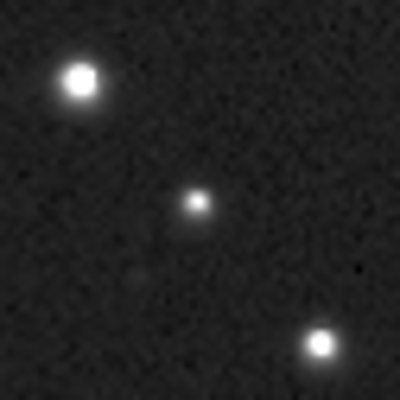

In [5]:
# get processed image data
APIURL = 'https://fink-portal.org'
r = requests.post(
    '{}/api/v1/cutouts'.format(APIURL),
    json={
        'objectId': oid,
        'kind': 'Template',
        'stretch': 'sqrt',
    }
)

image = im.open(io.BytesIO(r.content))
image.resize((400, 400))


In [6]:
print(r.headers['Content-Type'])


image/png


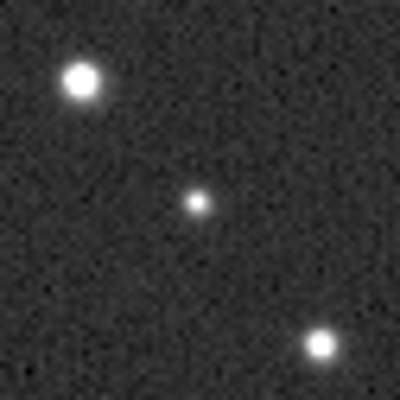

In [6]:


# get processed image data
APIURL = 'https://fink-portal.org'
r = requests.post(
    '{}/api/v1/cutouts'.format(APIURL),
    json={
        'objectId': oid,
        'kind': 'Science',
        'stretch': 'sqrt'
    }
)

image = im.open(io.BytesIO(r.content))
image.resize((400, 400))



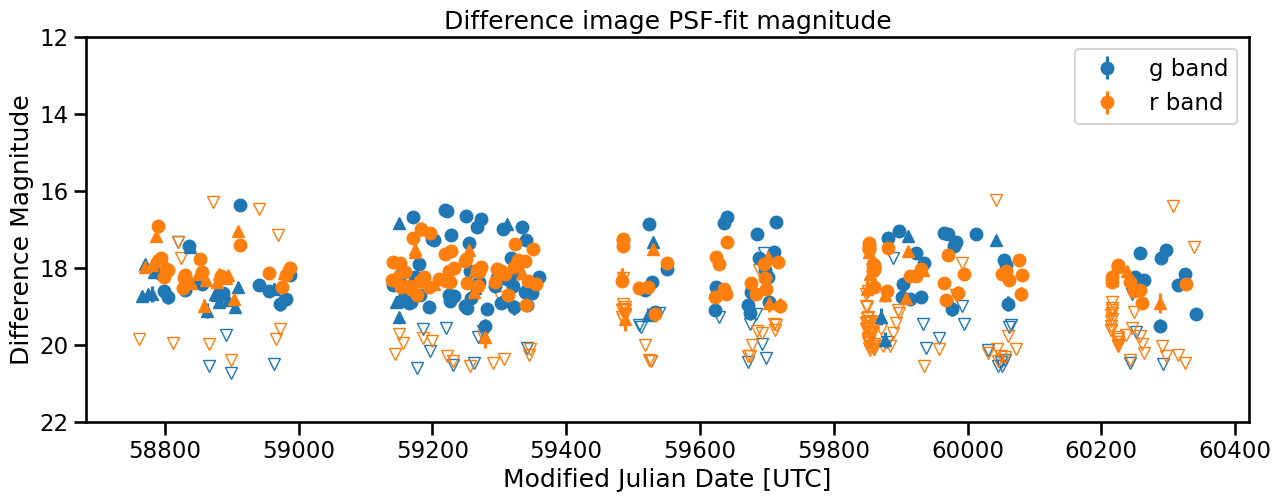

In [7]:


mjd = pdf_magpsf['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt

    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid'
    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    plt.plot(
        pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    plt.errorbar(
        pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
        pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



In [18]:
pdf_magpsf.shape


(473, 168)

In [133]:
pdf_magpsf['i:candid']

0      2587253542915010008
1                       -1
2      2572399872915010002
3                       -1
4      2570377142915015008
              ...         
468                     -1
469                     -1
470                     -1
471                     -1
472                     -1
Name: i:candid, Length: 473, dtype: int64

In [21]:
for i in range(473):
    print(pdf_magpsf['i:magnr'][i], pdf_magpsf['d:tag'][i], pdf_magpsf['i:isdiffpos'][i], pdf_magpsf['i:isdiffpos'][i] == 'r')
    print()
    

16.762001 valid f False

nan upperlim None False

16.388 valid f False

nan upperlim None False

16.762001 valid t False

nan badquality None False

nan upperlim None False

16.762001 valid t False

nan upperlim None False

16.762001 valid t False

nan upperlim None False

nan upperlim None False

nan upperlim None False

16.762001 valid t False

16.762001 valid f False

nan badquality None False

16.762001 valid t False

nan upperlim None False

nan upperlim None False

16.388 valid t False

16.388 valid t False

nan upperlim None False

16.762001 valid t False

16.388 valid f False

nan upperlim None False

16.762001 valid t False

16.762001 valid t False

16.388 valid f False

nan upperlim None False

nan upperlim None False

nan upperlim None False

16.388 valid f False

nan upperlim None False

nan upperlim None False

nan badquality None False

nan upperlim None False

nan upperlim None False

16.388 valid t False

16.388 valid t False

nan upperlim None False

16.388 valid t Fal

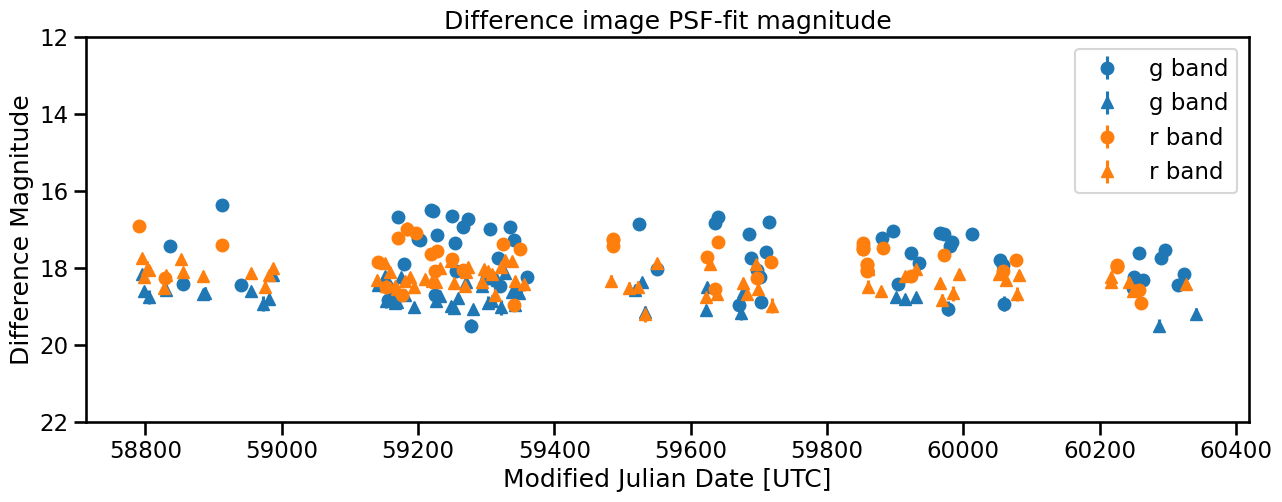

In [22]:

 
mjd = pdf_magpsf['i:jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf['i:fid']):
    maskFilt = pdf_magpsf['i:fid'] == filt
    # The column `d:tag` is used to check data type
    maskValid = pdf_magpsf['d:tag'] == 'valid' 
    maskneg = pdf_magpsf['i:isdiffpos'] == 't' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt & maskneg ]['i:sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    maskpos = pdf_magpsf['i:isdiffpos'] == 'f' 

    plt.errorbar(
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:magpsf'],
        pdf_magpsf[maskValid & maskFilt &  maskpos ]['i:sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    
    
    #pa pratique !
    maskUpper = pdf_magpsf['d:tag'] == 'upperlim'
    #plt.plot(pdf_magpsf[maskUpper & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),pdf_magpsf[maskUpper & maskFilt]['i:diffmaglim'],ls='', marker='o', color=colordic[filt],  )

    maskBadquality = pdf_magpsf['d:tag'] == 'badquality'
    #plt.errorbar(
    #    pdf_magpsf[maskBadquality & maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
    #    pdf_magpsf[maskBadquality & maskFilt]['i:magpsf'],
    #    pdf_magpsf[maskBadquality & maskFilt]['i:sigmapsf'],
    #    ls='', marker='o', color=colordic[filt])

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



In [23]:


# from fink_science.conversion import dc_mag
from fink_utils.photometry.conversion import dc_mag
from fink_utils.photometry.utils import is_source_behind

# Take only valid measurements
pdf_magpsf_valid = pdf_magpsf[pdf_magpsf['d:tag'] == 'valid'].sort_values('i:jd', ascending=False)

isSource = is_source_behind(
    pdf_magpsf_valid['i:distnr'].values[0]
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                pdf_magpsf_valid['i:magpsf'].astype(float).values,
                pdf_magpsf_valid['i:sigmapsf'].astype(float).values,
                pdf_magpsf_valid['i:magnr'].astype(float).values,
                pdf_magpsf_valid['i:sigmagnr'].astype(float).values,
                pdf_magpsf_valid['i:isdiffpos'].values
            )
        ]
    )
    
    pdf_magpsf_valid['i:mag_dc'] = mag_dc
    pdf_magpsf_valid['i:err_dc'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    pdf_magpsf_valid['i:mag_dc'] = pdf_magpsf_valid['i:magpsf']
    pdf_magpsf_valid['i:err_dc'] = pdf_magpsf_valid['i:sigmapsf']



It looks like there is a source behind. Lets compute the DC magnitude instead.


In [95]:
mean = pdf_magpsf_valid['i:mag_dc'].mean()
print(mean)

16.51735064309925


In [37]:
for i in range(473):
    a=1
    #print(pdf_magpsf['i:magnr'][i], pdf_magpsf['d:tag'][i], pdf_magpsf['i:fid'][i])
    
    

    

print(ref_r, ref_g)

#mean_psf_r = (mean_psf_r[mean_psf_r != 0]).mean()


0      16.762001
2       0.000000
4      16.762001
7      16.762001
9      16.762001
         ...    
458    16.762001
459     0.000000
460    16.762001
461     0.000000
462     0.000000
Length: 231, dtype: float64
16.388 16.762001000000005


16.388 16.762001000000005


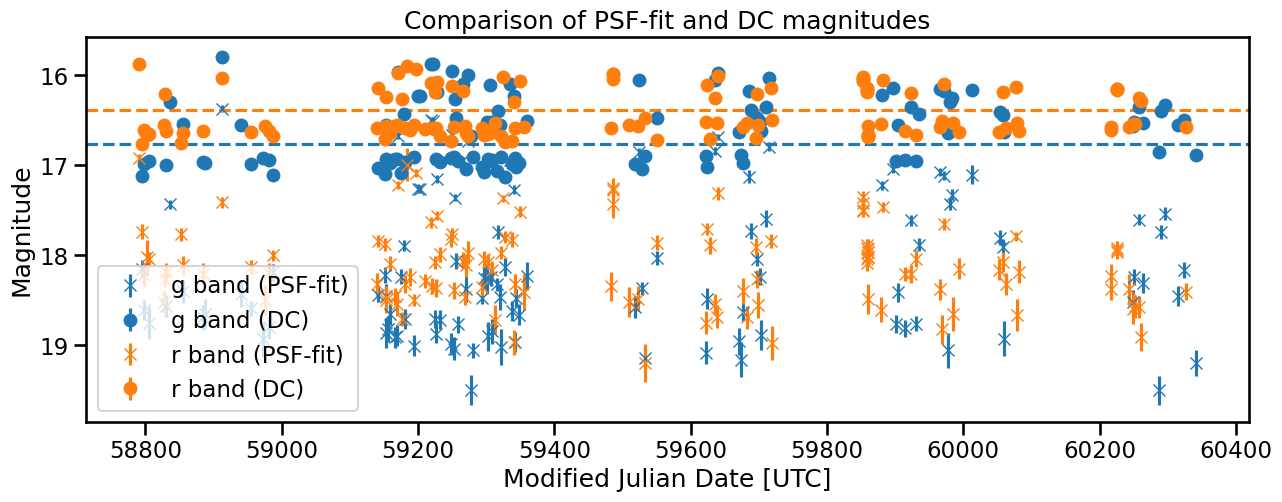

In [41]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )


ref_r = pdf_magpsf_valid['i:magnr']*(pdf_magpsf_valid['i:fid']==2)

ref_r = (ref_r[ref_r != 0]).mean()

ref_g = pdf_magpsf_valid['i:magnr']*(pdf_magpsf_valid['i:fid']==1)

ref_g = (ref_g[ref_g != 0]).mean()


print(ref_r, ref_g)

plt.axhline(y=ref_r, color=colordic[2], linestyle='--')
plt.axhline(y=ref_g, color=colordic[1], linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

18.105832266666667


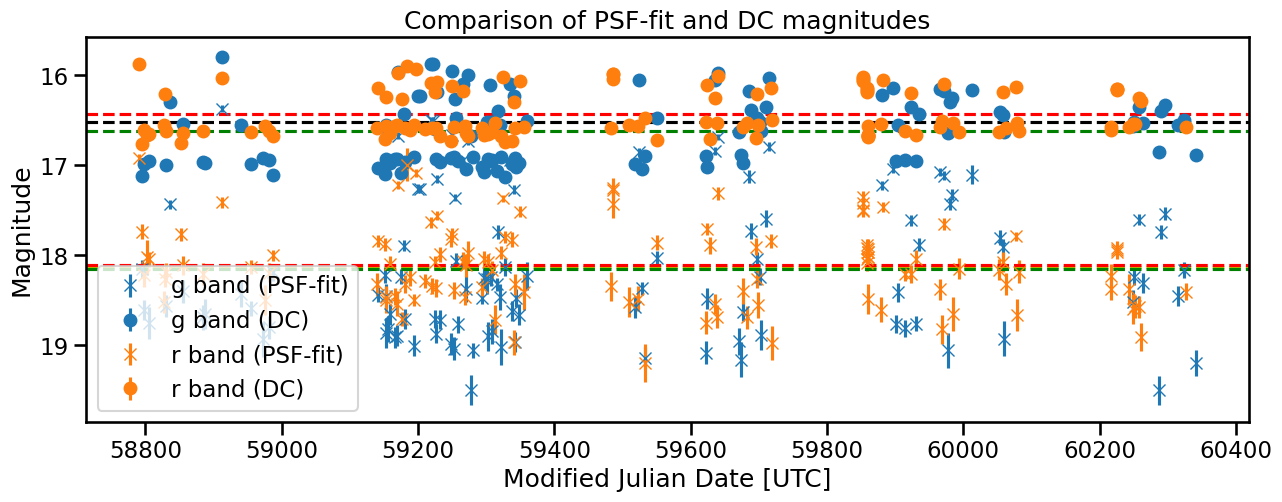

In [27]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
moy_dc_1= 0  
for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    #moy_dc_1 += pdf_magpsf_valid[maskFilt]['i:mag_dc'].mean # * (maskFilt)

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
lignes = pdf_magpsf_valid.shape



mean_dc = pdf_magpsf_valid['i:mag_dc'].mean()
mean_psf = pdf_magpsf_valid['i:magpsf'].mean()

mean_psf_r = (pdf_magpsf_valid['i:magpsf']*(pdf_magpsf_valid['i:fid']==2))
mean_psf_r = (mean_psf_r[mean_psf_r != 0]).mean()


mean_psf_g = (pdf_magpsf_valid['i:magpsf']*(pdf_magpsf_valid['i:fid']==1))
mean_psf_g = (mean_psf_g[mean_psf_g != 0]).mean()

mean_dc_r = (pdf_magpsf_valid['i:mag_dc']*(pdf_magpsf_valid['i:fid']==2))
mean_dc_r = (mean_dc_r[mean_dc_r != 0]).mean()


mean_dc_g = (pdf_magpsf_valid['i:mag_dc']*(pdf_magpsf_valid['i:fid']==1))
mean_dc_g = (mean_dc_g[mean_dc_g != 0]).mean()


print(mean_psf_r)
plt.axhline(y=mean_dc, color='k', linestyle='--')
plt.axhline(y=mean_psf, color='y', linestyle='--')
plt.axhline(y=mean_dc_r, color='r', linestyle='--')
plt.axhline(y=mean_dc_g, color='g', linestyle='--')

plt.axhline(y=mean_psf_r, color='r', linestyle='--')
plt.axhline(y=mean_psf_g, color='g', linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

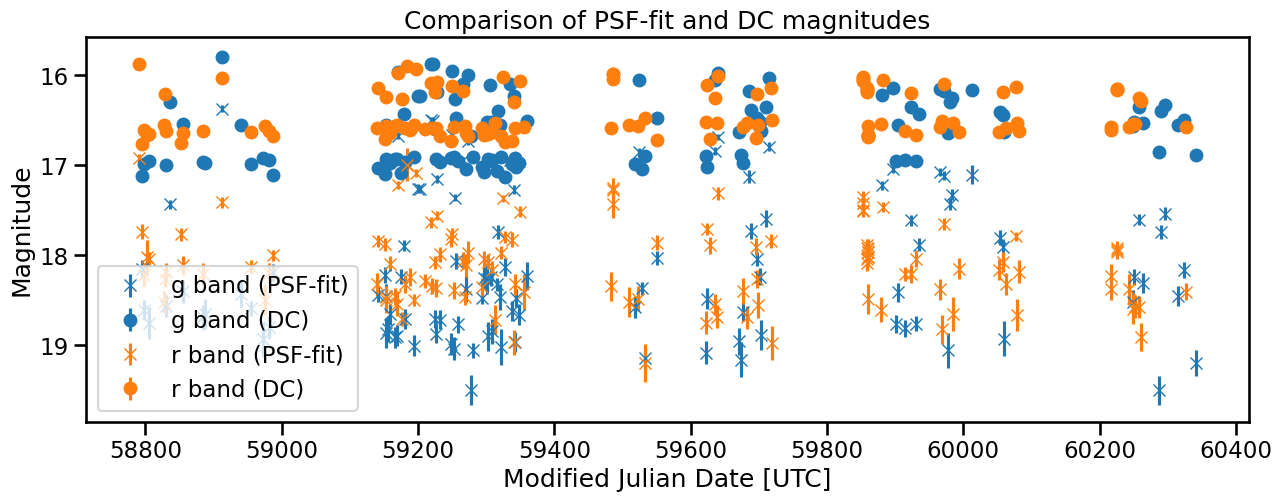

In [13]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt

    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:magpsf'],
        pdf_magpsf_valid[maskFilt]['i:sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');



In [14]:
ra0 = np.mean(pdf_magpsf_valid['i:ra'].values)
dec0 = np.mean(pdf_magpsf_valid['i:dec'].values)

r = requests.post(
    'https://irsa.ipac.caltech.edu/cgi-bin/ZTF/nph_light_curves', 
    data={'POS': 'CIRCLE {} {} 0.0004'.format(ra0, dec0), 
          'BAD_CATFLAGS_MASK': 32768, 
          'FORMAT': 'csv'
         }
)

pdf_ZTF = pd.read_csv(io.StringIO(r.text))

In [15]:
pdf_ZTF


,oid,expid,hjd,mjd,mag,magerr,catflags,filtercode,ra,dec,...,ccdid,qid,limitmag,magzp,magzprms,clrcoeff,clrcounc,exptime,airmass,programid
0,467108200005771,44825559,2.458203e+06,58202.255590,16.920856,0.017711,0,zg,141.224922,4.263803,...,0x8,0x2,20.379999,26.265512,0.034776,-0.048568,0.000030,30,1.172,1
1,467108200005771,45326015,2.458208e+06,58207.260150,16.443258,0.014962,0,zg,141.224912,4.263788,...,0x8,0x2,19.820000,26.255278,0.041898,-0.041420,0.000070,30,1.211,1
2,467108200005771,45328714,2.458208e+06,58207.287141,16.581160,0.015630,0,zg,141.224927,4.263792,...,0x8,0x2,19.700001,26.169960,0.036795,-0.020290,0.000055,30,1.304,1
3,467108200005771,45623189,2.458211e+06,58210.231898,16.547821,0.015460,0,zg,141.224916,4.263786,...,0x8,0x2,19.719999,25.930735,0.042229,-0.034206,0.000073,30,1.169,1
4,467108200005771,45625666,2.458211e+06,58210.256667,16.669701,0.016109,0,zg,141.224923,4.263780,...,0x8,0x2,19.750000,25.913187,0.039007,-0.033046,0.000061,30,1.224,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,1461216100003621,144447929,2.459199e+06,59198.479294,16.423637,0.013733,0,zr,141.224964,4.263803,...,0x10,0x1,21.100000,27.678829,0.020657,0.099988,0.000007,120,1.185,3
849,1461216100003621,144550267,2.459200e+06,59199.502674,16.052452,0.011961,0,zr,141.224963,4.263818,...,0x10,0x1,21.010000,27.668224,0.021584,0.100692,0.000008,120,1.189,3
850,1461216100003621,144747321,2.459202e+06,59201.473218,16.480900,0.014081,0,zr,141.224961,4.263789,...,0x10,0x1,21.420000,27.684265,0.019206,0.097905,0.000007,120,1.184,3
851,1461216100003621,144852343,2.459203e+06,59202.523438,16.226810,0.012697,0,zr,141.224956,4.263821,...,0x10,0x1,20.900000,27.665831,0.022635,0.103937,0.000009,120,1.232,3


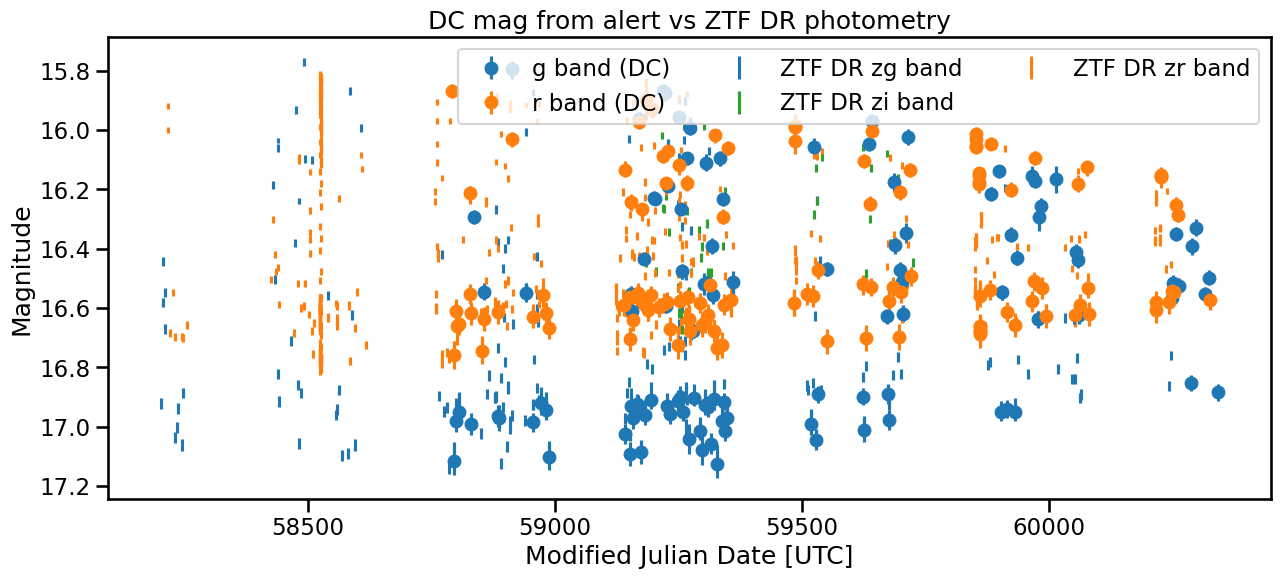

In [16]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

f = pdf_ZTF['catflags'] == 0
colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf_ZTF[f]['filtercode']):
    maskFilt = pdf_ZTF[f]['filtercode'] == filt
    plt.errorbar(
        pdf_ZTF[f][maskFilt]['mjd'], 
        pdf_ZTF[f][maskFilt]['mag'], 
        pdf_ZTF[f][maskFilt]['magerr'], 
        ls='', color=colordic[filt],
        label='ZTF DR {} band'.format(filt))

plt.gca().invert_yaxis()
plt.legend(ncol=3)
plt.title('DC mag from alert vs ZTF DR photometry')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

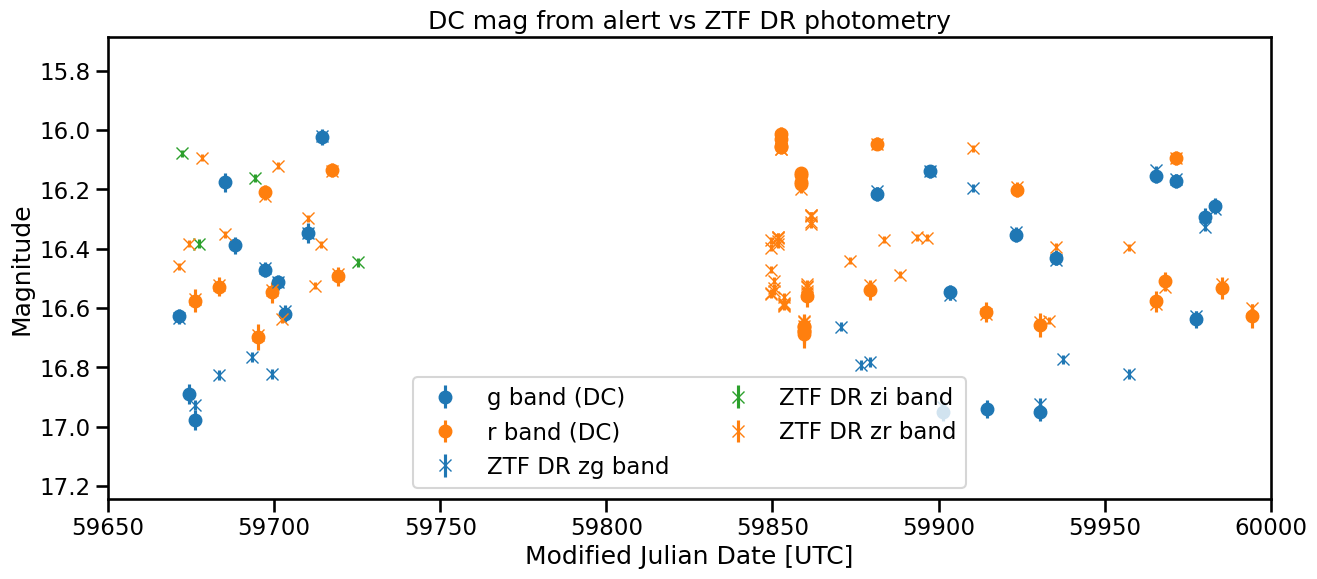

In [17]:
fig = plt.figure(figsize=(15, 6))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(pdf_magpsf_valid['i:fid']):
    maskFilt = pdf_magpsf_valid['i:fid'] == filt
    
    plt.errorbar(
        pdf_magpsf_valid[maskFilt]['i:jd'].apply(lambda x: x - 2400000.5),
        pdf_magpsf_valid[maskFilt]['i:mag_dc'],
        pdf_magpsf_valid[maskFilt]['i:err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )

f = pdf_ZTF['catflags'] == 0
colordic = {'zg': 'C0', 'zr': 'C1', 'zi': 'C2'}
for filt in np.unique(pdf_ZTF[f]['filtercode']):
    maskFilt = pdf_ZTF[f]['filtercode'] == filt
    plt.errorbar(
        pdf_ZTF[f][maskFilt]['mjd'], 
        pdf_ZTF[f][maskFilt]['mag'], 
        pdf_ZTF[f][maskFilt]['magerr'], 
        ls='', color=colordic[filt], marker='x',
        label='ZTF DR {} band'.format(filt))

plt.gca().invert_yaxis()
plt.legend(ncol=2)
plt.title('DC mag from alert vs ZTF DR photometry')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude')
plt.xlim(59650, 60000);


In [ ]:


pdf = pd.read_csv('ZTF18adbhpeb.csv', comment='#', sep=' ')

pdf = pdf\
    .drop(columns=['Unnamed: 0'])\
    .rename(lambda x: x.split(',')[0], axis='columns')



In [ ]:
pdf